# PyTorch - How to use the GPU
Most of the computations that are done when training your deep learning model will consist of matrix multiplications. GPUs are optimized for these type of computations and can therefore greatly decrease the time it takes to train your model. When your models become larger, this can save hours or even days of training. This lab explains how to use the GPU in PyTorch.

We recommend you use the GPU provided by Colab instead of the one in your laptop, as these are much better and also simplify the tool installation. Also, PyTorch makes use of CUDA, which is a platform for general purpose computing on GPUs. Not all GPUs are compatible with CUDA.

PyTorch tensors are either allocated on the CPU or GPU. Tensors located on the CPU cannot interact with those on the GPU and vice versa. This is something you need to keep track of when programming your models.

In [1]:
import torch

If you are working in Colab, try enabling the GPU by, in the menu above, selecting 'Runtime' and 'Change runtime type'.

In [2]:
if torch.cuda.is_available():
  print('GPU is available!')
  device = torch.device('cuda')
else:
  print('GPU is not available!')
  device = torch.device('cpu')

GPU is available!


Next, we allocate some tensors on both the CPU and GPU.

In [3]:
tensor_1 = torch.randn(4, device=torch.device('cpu'))   # CPU tensor
tensor_2 = torch.randn(4, device=torch.device('cuda'))  # GPU tensor
tensor_3 = torch.randn(4, device=device)                # Initialized on the device being used
tensor_4 = torch.randn(4)                               # By default, tensors are initialized as CPU tensors
tensor_5 = torch.FloatTensor([1,2,3,4])                 # CPU tensor
tensor_6 = torch.cuda.FloatTensor([1,2,3,4])            # GPU tensor


/tmp/ipython-input-1237815182.py:6: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at /pytorch/torch/csrc/tensor/python_tensor.cpp:78.)
  tensor_6 = torch.cuda.FloatTensor([1,2,3,4])            # GPU tensor


Since the following tensors are not allocated on the same device, they cannot be multiplied:

In [4]:
tensor_1 * tensor_2

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

The .to() function can be used to move a tensor from one device to another. However, the usage of this function should be minimized, as it is a relatively expensive operation.

In [5]:
tensor_3 * tensor_4.to(device)

tensor([-2.5841, -0.0954,  0.1201,  0.3811], device='cuda:0')

Since model parameters are tensors, they are allocated on either the CPU or GPU as well. Therefore, models allocated on some device cannot process data on another device. Using the .to() function it is possible to move entire models between devices as well (if they extend torch.nn.Module).

In [6]:
from torch.nn import Module, Parameter

# Define a small Module example to move between devices
class Neuron(Module):

  def __init__(self):
    super(Neuron, self).__init__()
    self.weights = Parameter(torch.randn(4))
    self.bias = Parameter(torch.randn(1))

  def forward(self, x):
    return torch.sigmoid(torch.sum(self.weights * x) + self.bias)


neuron = Neuron().to(device)
neuron.forward(tensor_3)

tensor([0.2638], device='cuda:0', grad_fn=<SigmoidBackward0>)

### Exercise
Try modifying the code below such that the training loop uses the GPU

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [8]:
# This code does not need to be modified!

class TwoLayerNet(nn.Module):

    def __init__(self, input_size, hidden_size1, output_size):
        super(TwoLayerNet , self).__init__()

        self.layer1 = nn.Linear(input_size, hidden_size1, bias=False)
        self.layer2 = nn.Linear(hidden_size1, output_size, bias=False)

    def forward(self, x):
        y       = self.layer1(x)
        y_hat   = F.relu(y)
        z       = self.layer2(y_hat)
        return F.softmax(z, dim=1)


In [9]:
# This code does not need to be modified!

import torchvision.datasets
import torchvision.transforms as transforms

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Lambda(lambda x: x.squeeze()),
                                ])

trainset = torchvision.datasets.MNIST(root='./data_mnist',
                                      train=True,
                                      download=True,
                                      transform=transform
                                      )

testset = torchvision.datasets.MNIST(root='./data_mnist',
                                     train=False,
                                     download=True,
                                     transform=transform
                                     )



100%|██████████| 9.91M/9.91M [00:00<00:00, 18.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 486kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.70MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.69MB/s]


In [21]:
# This code does not need to be modified!

bs=128



cuda_generator = torch.Generator(device=device)

trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=bs,
                                          shuffle=True,
                                          drop_last=True,
                                          generator=cuda_generator
                                          )

testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=bs,
                                         shuffle=True,
                                         drop_last=True,
                                         generator=cuda_generator
                                         )

In [22]:
net=TwoLayerNet(784, 64, 10).to(device)  # Move the model to GPU

criterion = nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(net.parameters() , lr=0.1)

for epoch in range(1, 5):

  for i, (minibatch_data, minibatch_label) in enumerate(trainloader):
      minibatch_data, minibatch_label = minibatch_data.to(device), minibatch_label.to(device)  # Move the data to GPU

      # Set dL/dU, dL/dV, dL/dW to be filled with zeros
      optimizer.zero_grad()

      #reshape the minibatch
      inputs = minibatch_data.view(bs, 784)

      # forward the minibatch through the net
      prob=net(inputs)

      # Compute the average of the losses of the data points in the minibatch
      loss = criterion(prob , minibatch_label)

      # backward pass to compute dL/dU, dL/dV and dL/dW
      loss.backward()

      # do one step of stochastic gradient descent: U=U-lr(dL/dU), V=V-lr(dL/dU), ...
      optimizer.step()

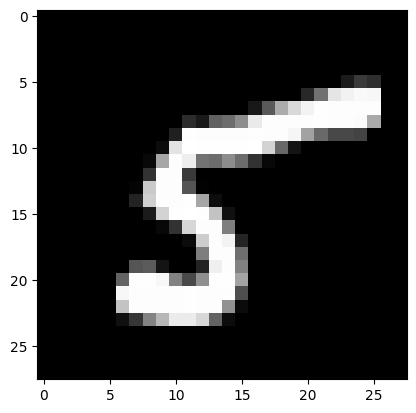

Confidence scores:
0: 0.009759895503520966
1: 2.3174209218268516e-06
2: 2.1914970602665562e-06
3: 8.819512004265562e-06
4: 3.8049204249546165e-06
5: 0.9892059564590454
6: 5.413735948422982e-07
7: 8.725424413569272e-05
8: 0.0009286931017413735
9: 4.706622576122754e-07

Label with highest confidence score: 5


In [24]:
# This code does not need to be modified!

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

# choose a picture at random
im_minibatch, label_minibatch = next(iter(testloader))
im, label = im_minibatch[0].cpu(), label_minibatch[0].cpu()

# Function to show an image tensor
def show(X):
    if X.dim() == 3 and X.size(2) == 3:
        plt.imshow(X.numpy())
        plt.show()
    elif X.dim() == 2:
        plt.imshow(   X.numpy() , cmap='gray'  )
        plt.show()
    else:
        print('WRONG TENSOR SIZE')

# diplay the picture
show(im)

# feed it to the net and display the confidence scores
prob = net.cpu()(im.view(1,784))

print('Confidence scores:\n' + '\n'.join(['{}: {}'.format(i, p.item()) for i, p in enumerate(prob.squeeze())]))

print('\nLabel with highest confidence score: {}'.format(torch.argmax(prob).item()))
